In [14]:
import cv2
import os
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np 
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [15]:
path="skin tone detection\Prathepan_dataset\FacePhoto"
path1="skin tone detection\Prathepan_dataset\Ground_Truth\GroundT_FacePhoto"
images=os.listdir(path)
images1=os.listdir(path1)

In [16]:
img_arr=[]
img_arr1=[]

In [17]:
for img in range(0,len(images)):
    img_arr.append(os.path.join(path,images[img]))
    img_arr1.append(os.path.join(path1,images1[img]))

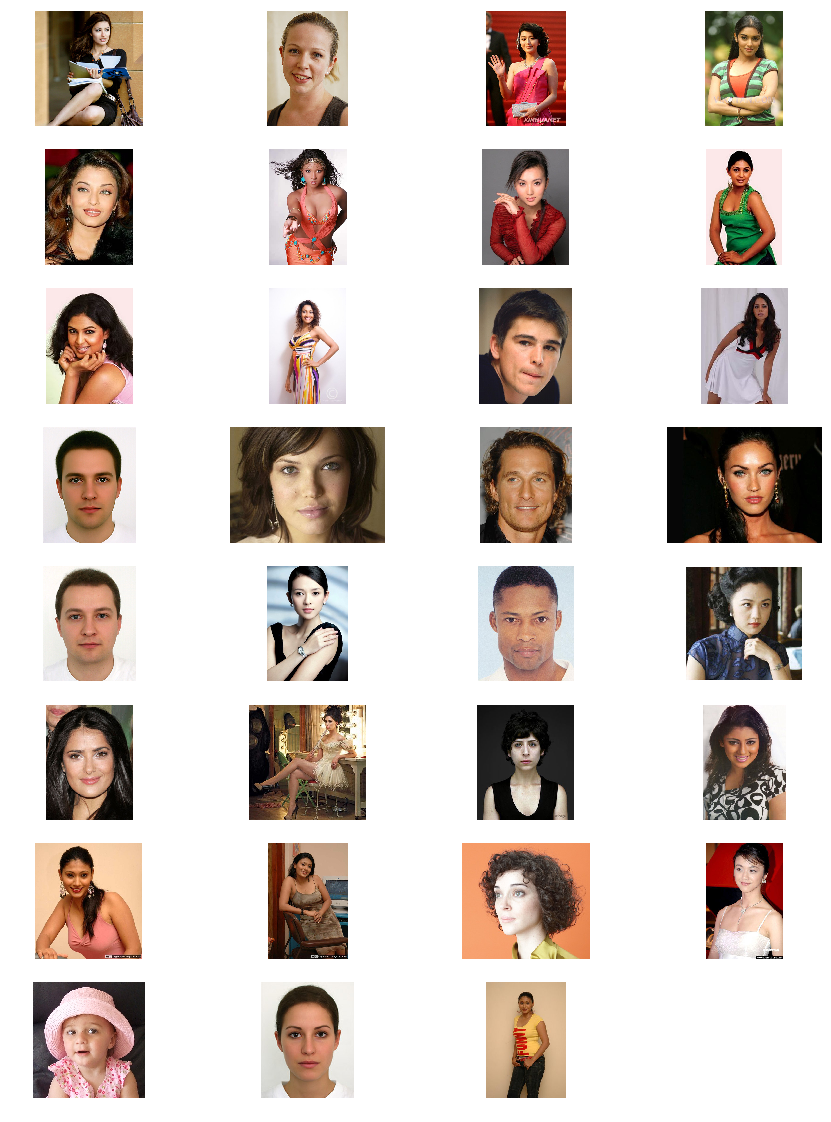

In [87]:
len(img_arr)
j=0
plt.figure(figsize=(15,20))
for i in img_arr:
    c=cv2.imread(i)
    c=cv2.cvtColor(c,cv2.COLOR_BGR2RGB)
    plt.subplot(8,4,j+1)
    plt.imshow(c)
    plt.axis('off')
    j=j+1

In [19]:
face_cascade=cv2.CascadeClassifier('DATA/haarcascades/haarcascade_frontalface_default.xml')

In [20]:
output={}

In [21]:
def detect_face(img):
    img = cv2.imread(img, 0)
    face_img = img.copy()

    face_rects = face_cascade.detectMultiScale(face_img,1.2,5)
    [x,y,w,h]=face_rects[0,:]
#     for (x, y, w, h) in face_rects:
#         cv2.rectangle(face_img, (x, y), (x + w, y + h), (255, 255, 255), 10)
#       
    
    return [x,y,w,h]

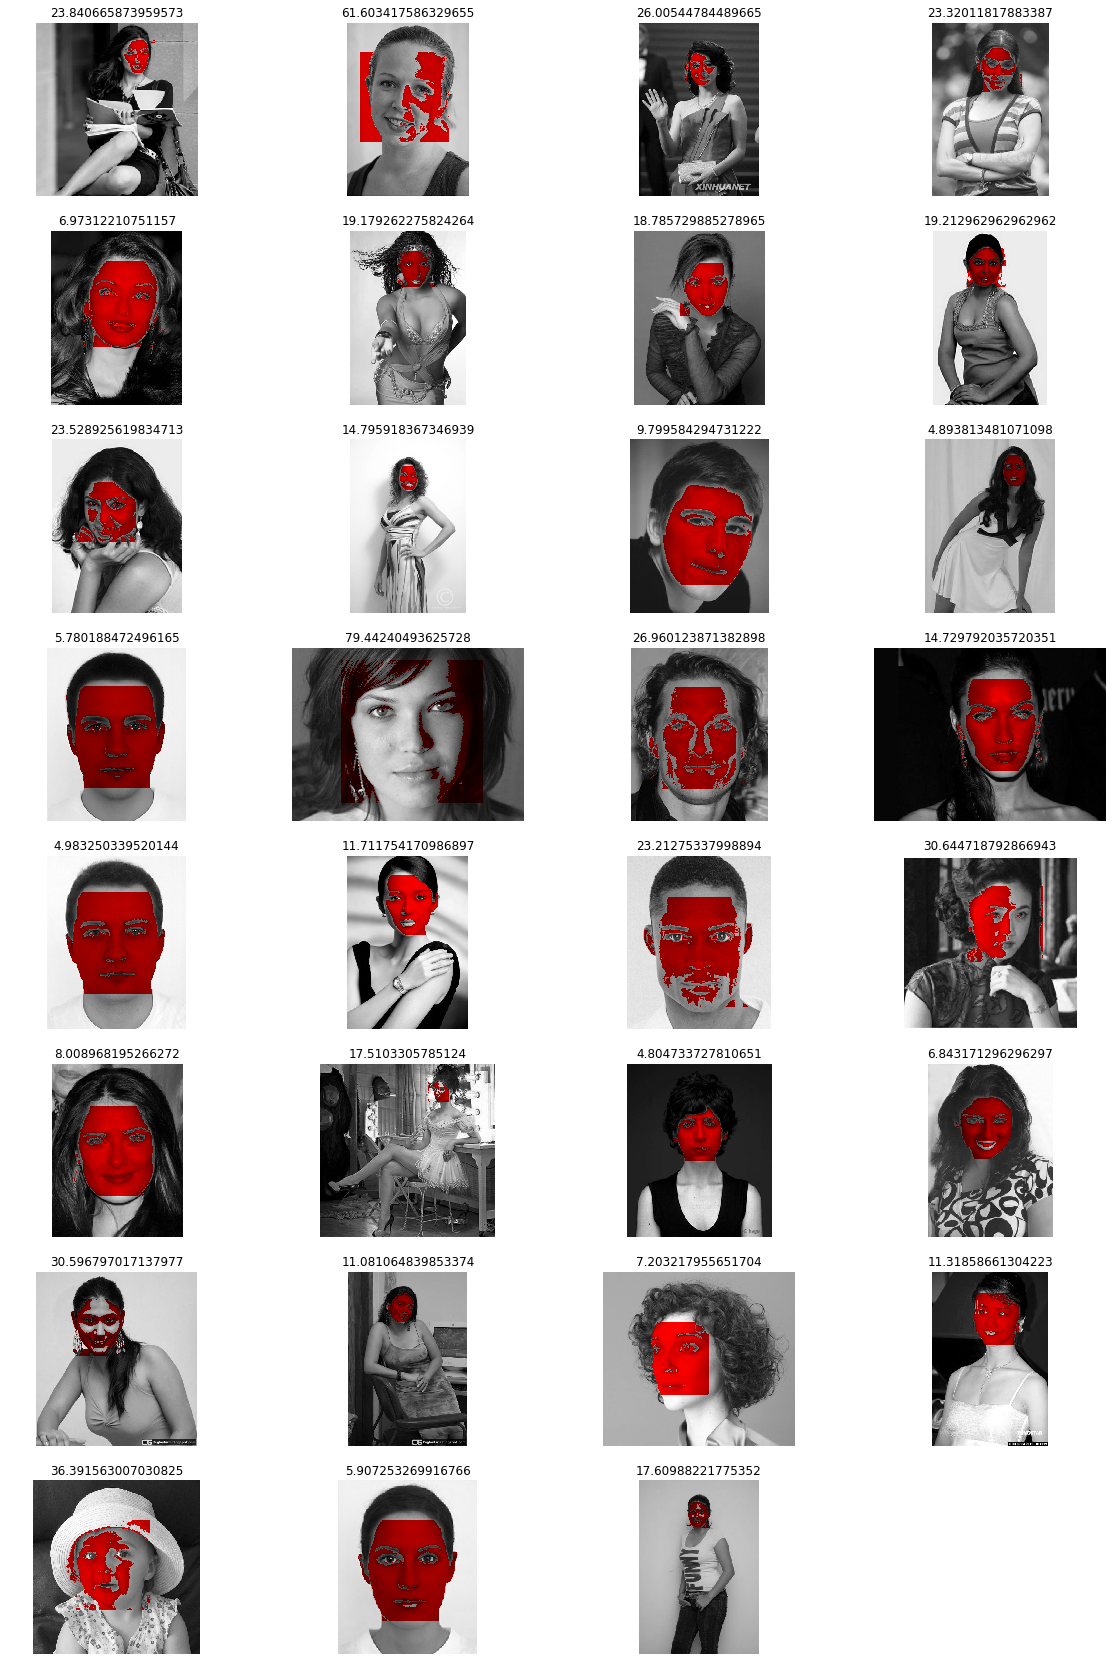

In [88]:
j=0
plt.figure(figsize=(20,30))
for x in range(len(img_arr)):
    i=img_arr[x]
    y=img_arr1[x]
    
    img=detect_face(i)
    output[i]=img
    input_img=cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB)
    output_img=cv2.cvtColor(cv2.imread(y),cv2.COLOR_BGR2RGB)
    [a,b,c,d]=img
    input_mask=input_img[b:b+c,a:a+d]
    output_mask=output_img[b:b+c,a:a+d]
    input_mask_hsv=color.rgb2hsv(input_mask)
    output_mask_hsv=color.rgb2hsv(output_mask)

    [hmain,wmain,dim]=input_img.shape
    [w,h,dd]=input_mask_hsv.shape
    
    
    feature_vector=np.zeros([w*h,dd])
    for cnt in range(0,dd):
        feature_vector[:,cnt]=input_mask_hsv[:,:,cnt].reshape(w*h)
    kmeans=KMeans(n_clusters=3,init='random',n_init=10,max_iter=100,tol=1e-04,random_state=0)
    y_kmeans=kmeans.fit_predict(feature_vector)
    kmeans_output_img=y_kmeans.reshape([w,h])
    
    cnt=np.zeros(3)
    for i in range(3):
        cnt[i]=np.sum(kmeans_output_img==i)
    skin_cluster_idx=np.argmax(cnt)
    skin_map=np.zeros([w,h],dtype='i2')
    skin_map[kmeans_output_img==skin_cluster_idx]=1
    
    skin_main_map=np.zeros([hmain,wmain])
    color_mask_final=np.zeros([hmain,wmain,dim])
    skin_main_map[b:b+c,a:a+d]=skin_map
    color_mask_final[skin_main_map==1]=[1,0,0]
    gray_img=color.rgb2gray(input_img)
    final_gray_img=np.dstack([gray_img,gray_img,gray_img])
    color_mask_hsv=color.rgb2hsv(color_mask_final)
    final_gray_img_hsv=color.rgb2hsv(final_gray_img)
    final_gray_img_hsv[:,:,0]=color_mask_hsv[:,:,0]
    final_gray_img_hsv[:,:,1]=color_mask_hsv[:,:,1]
    final_img=color.hsv2rgb(final_gray_img_hsv)
    
    zz=output_mask_hsv[:,:,2]-skin_map
    Freqcount=np.count_nonzero(zz==-1)
    Freqcount+=np.count_nonzero(zz==1)
    total_pixel=w*h
    error=100*(Freqcount/total_pixel)
    
    plt.subplot(8,4,j+1)
    plt.imshow(final_img)
    plt.title(error)
    plt.axis('off')
    j=j+1